- does lspi work?
    - linear yes...
    - rbf no...
- how does lspi behave according to D? 
    - only optimal - yes
    - noisy optimal
    - completely random
- how does lspi behave according to D? 
    - only optimal
    - noisy optimal
    - completely random

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from env.simulator import * 
from util.plotting import *
from util.basis import *

In [2]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
action_list = range(env.action_space.n)
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
pi = NearExpertPolicy()
#pi = RandomPolicy2(action_list)
D, stats = sim.simulate(pi=pi, n_trial=1, n_episode=100, return_stats=True)

Step 84 @ Episode 100/100 (-86.0))

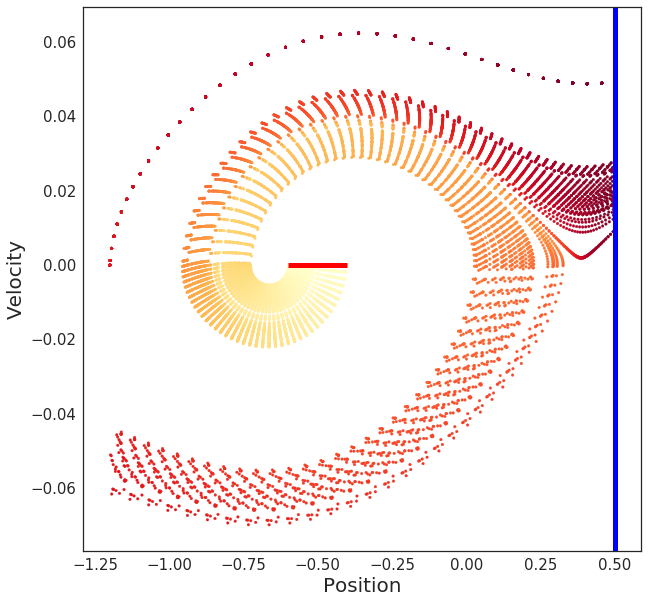

In [4]:
#plot_cost_to_go_mountain_car(env, pi_irl._estimator)
#plot_episode_stats(stZts, smoothing_window=5)
#dir(Simulator.to_matrix)
plot_trajectory_mountain_car(D)

In [5]:
# linear basis func
p_linear = 3
q_linear = 3
phi_linear = simple_phi
psi_linear = phi_linear
p_rbf = 100
q_rbf = 100
phi_rbf = get_rbf_basis(env)
psi_rbf = phi_rbf
p = p_linear
q = q_linear
phi = phi_linear
psi = psi_linear
precision = 0.1
eps = 0.001
gamma = 0.95

def solve_mountain_car_linear(p, phi, gamma, precision, eps, D):
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=None)

    W = lspi.solve()
    return W
    
def solve_mountain_car_rbf(p, phi, gamma, precision, eps, D):  
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=None)

    W = lspi.solve()
    return W

In [7]:
D = Simulator.to_matrix(D)
print("batch data size {}".format(D.shape))
W_linear = solve_mountain_car_linear(p_linear, phi_linear, gamma, precision, eps, D)
#W_rbf = solve_mountain_car_rbf(p_rbf, phi_rbf, gamma, precision, eps, D)

batch data size (12210, 5)
Step 1 @ norm 0.05.088332594511

Step 153 @ Episode 50/50 (-154.0)

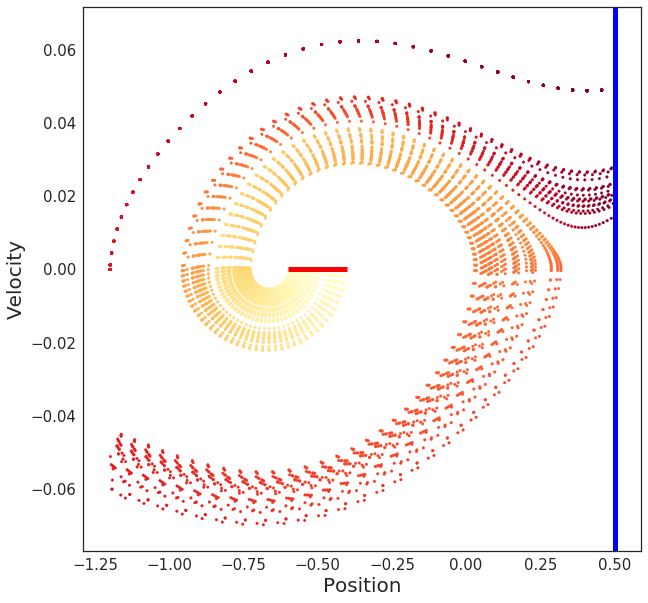

In [9]:
#phi = phi_rbf
phi = phi_linear
pi_star = LinearQ2(action_list=action_list, phi=phi, W=W_linear)
D_star, stats = sim.simulate(pi=pi, n_trial=1, n_episode=50, return_stats=True)
plot_trajectory_mountain_car(D_star)